# Subsetting a watershed using Raven and Flyingpigeon

Here we use the processes from two PAVICS/Birdhouse services to perform an analysis based on an upstream watershed delineation

In [1]:
# Import the necessary libraries to format, send, and parse our returned results

%matplotlib inline

import birdy
import json
import xarray as xr
import requests
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
from example_data import TESTDATA
import os


Assuming that you are running the Raven and FlyingPigeon modules locally, the default ports that the WPS services are mapped to are as follows:

* **Raven: http://localhost:9099/wps**
* **Flyingpigeon: http://localhost:8093/wps**


In [2]:
# url_raven = "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps"
url_flyingpigeon = os.environ.get("FLYINGPIGEON_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/flyingpigeon/wps")

url_raven = os.environ.get("RAVEN_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")

raven = birdy.WPSClient(url_raven) #, progress=True)
fp = birdy.WPSClient(url_flyingpigeon) # , progress=True)

Let's consider trying to identify a sub-basin and all the upstream basins that flow into Lac Mistassini (Rupert Watershed) of Northern Quebec. Lac Mistassini is roughly found at 51.0 North, 73.621 West.

We'll start by launching a process with Raven to find the upstream watersheds and return us both a GeoJSON of this watershed as well as the feature IDs of all the sub-basins.

In [3]:
basin_process = raven.hydrobasins_select(
    location="-73.621, 51.000", aggregate_upstream=True)

# Wait for the process to complete before continuing with calculations

Number of subbasins: 325


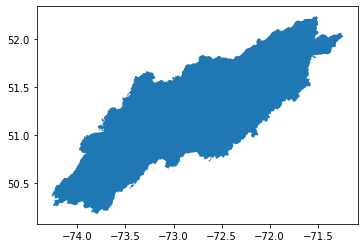

In [4]:
# Collecting the response
feature, upstream_ids = basin_process.get(asobj=True)

# Plot our vector shapefile
df = gpd.GeoDataFrame.from_features([feature])
df.plot()

print("Number of subbasins: {}".format(len(upstream_ids)))

The upstream IDs are WFS addresses to the individual features from the vector data present on GeoServer. So long as we know the address of the GeoServer, we can use these addresses to pull data from the data server and launch processes using a PAVICS/Birdhouse process that is located elsewhere. Here we'll only pull data from the first two subbasins. 

In [5]:
# NBVAL_SKIP

# Address of the GeoServer where the HydroBASINS data is pulled from
geoserver = "https://pavics.ouranos.ca/geoserver/wfs"

# A local address of a NetCDF file
# A link to a remote file or the path to a local file. 
nc1 = str(TESTDATA["cmip5_subset"])

resp = fp.subset_wfs_polygon(
    resource=nc1,
    typename="public:USGS_HydroBASINS_lake_na_lev12", # The store and name of the data set 
    geoserver=geoserver, # The address of the GeoServer
    featureids=upstream_ids[:2], # The IDs of the individual features
    mosaic=False,
)

Metalink content-type detected.


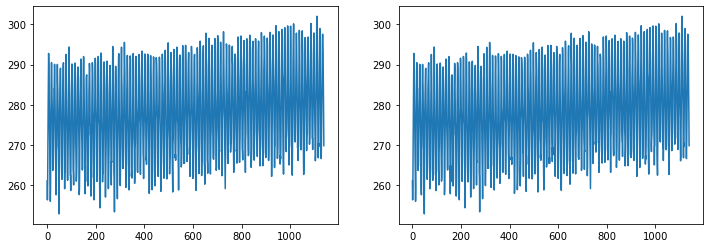

In [6]:
# NBVAL_SKIP

# The response from the process is the first netCDF file (as an easy to inspect example),
# and a Metalink file storing the links to all the files created. 
# Note that you need to have pymetalink installed for this to work. 
ds, meta = resp.get(asobj=True)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(meta[0].tas)
axes[1].plot(meta[1].tas)

We can also aggregate multiple subbasins to get a single file. Note however that due to a software limitation, no more than 220 upstream ids can be aggregated for now. 

In [7]:
resp = fp.subset_wfs_polygon(
    resource=nc1,
    typename="public:USGS_HydroBASINS_lake_na_lev12", # The store and name of the data set 
    geoserver=geoserver, # The address of the GeoServer
    featureids=upstream_ids[:10], # The IDs of the individual features
    mosaic=True,
)

Metalink content-type detected.


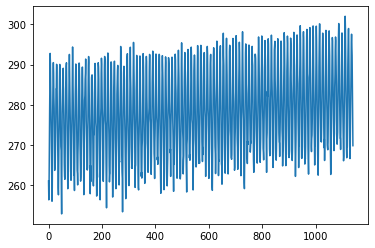

In [8]:
dsa, metaa = resp.get(asobj=True)
plt.plot(dsa.tas)